In [ ]:
!pip install --upgrade network

!pip install --upgrade mxnet
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for network: filename=network-0.1-py3-none-any.whl size=3155 sha256=4ad7f53c2189a22f57e90a8cfc751ccd3d6247033c2c43e47b0368d8bc25e2ff
  Stored in directory: /root/.cache/pip/wheels/59/17/3f/c2ad13bea3a1c250f52688f75437681a71e08c47622b82facb
Successfully built network
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4

In [ ]:

!pip install mxnet-cu112

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 3.2 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
import anvil.server


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
anvil.server.connect("server_ZUGYWX2VJYEPYJREVTQRYCM2-OUXEHI6Q2GOKV3KW")
NUM_NODE = 50
WEIGHT_MIN = .5
WEIGHT_MAX = 1.
const_list=[]
for i in range(15):
  flag=True
  while flag:
    index = random.randint(0, 49)
    if index not in const_list:
      const_list.append(index)
      flag=False


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:

def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=50,\
                          min_out_degree=2,\
                          max_out_degree=4,\
                          weight_min=WEIGHT_MIN,\
                          weight_max=WEIGHT_MAX,\
                          grid_size=20000):
    
    G = nx.Graph()
    
    num_of_passengers=0
    #dx=1/grid_size=1/20,000=0.00005
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)#[0.00000,0.00005,...,0.99995]
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)#permutated list of numbers from 0 to 20,000
    x_coords = euclidean_coords[coords_indices][:num_nodes]#permutated subset of euclidean_coords
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]#permutated subset of euclidean_coords
#     print(y_coords)
    
    # Add coordinates to nodes
    #(make nodes: set coordinites and define number of passengers from node to node)
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        
        amount=random.randrange(0,20,5)#number of passengers from the node
                                         
        num_of_passengers+=amount
        #nodes of distinations
        pdist=[0]*amount
        for i in range(amount):
          while True:
            pdist[i]=random.randint(0,len(x_coords))
            if pdist[i]!=coord[0]:
                break
              
        G.add_node(node, x=coord[0], y=coord[1],passengers=amount,dists=pdist)
    

    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])#list of other nodes odered by distance from this node
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)

        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                continue
            passengers=G.nodes[tmp_node[0]]['passengers']+G.nodes[node]['passengers']
            if tmp_node in const_list:
              weight= 0.3
            else:
              if passengers>=0 and passengers <=10:
                weight=0.9
              elif  passengers >10 and passengers <=20:
                weight =0.7
              elif passengers >20 and passengers <=30 :
                weight=0.5
              else:
                weight =1

            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
    print(num_of_passengers)
    return G

365
325
4
2
50
86
the nodes are : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


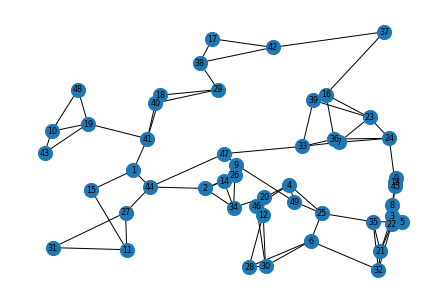

In [ ]:


G = generate_low_degree_g()
while nx.is_connected(G)==False:
  G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
print(f"the nodes are : {G.nodes}")
pos = {}
x=G.number_of_nodes
for t in G.nodes:
        pos[t] = (G.nodes[t]['x'], G.nodes[t]['y'])

nx.draw(G, pos=pos, node_size=200, font_size=8, with_labels=True)
plt.show()

In [ ]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def find_central_edge_greedy(G, start, depth=3):
    
    cur_node = start
    path = [cur_node]
    
    centrality_sum = 0.0
    
    for d in range(depth + 1):
        
        edge_tuples = map(lambda e:(e[0], e[1], G.get_edge_data(e[0], e[1])['centrality']),\
                  G.edges(cur_node))
        
        chosen_edge = max(edge_tuples, key=lambda t:t[2])
        
        assert cur_node == chosen_edge[0]
        cur_node = chosen_edge[1]
        
        # No point of getting trapped
        # in a dead loop;
        # just break out
        if cur_node in path:
            break
        
        centrality_sum += chosen_edge[2]
        path.append(cur_node)
    
    return centrality_sum

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, num_train_node_pairs=400,\
                                    num_test_node_pairs=100, verbose_frequence=100):
    
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    
    pair_path_dict = dict()
    
    train_selected_pairs = []
    test_selected_pairs = []
    num_of_nodes = G.number_of_nodes()
    
    train_mode = True
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        if (src, dst) in pair_path_dict:
            continue
        
        try:
            shortest_path = nx.dijkstra_path(G, src, dst)
                
        except NetworkXNoPath:
            continue
    
        for path in [shortest_path, shortest_path[::-1]]:
            
            src = path[0]
            dst = path[-1]
            
            pair_path_dict[(src, dst)] = path
            
            if train_mode and len(train_selected_pairs) < num_train_node_pairs:
                train_selected_pairs.append((src, dst))
            else:
                train_mode = False
                if len(test_selected_pairs) < num_test_node_pairs:
                    test_selected_pairs.append((src, dst))
                    
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

                if train_mode:
                    train_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    train_labels.append(mid_node)
                else:
                    test_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    test_labels.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
        if len(train_selected_pairs) >= num_train_node_pairs \
            and len(test_selected_pairs) >= num_test_node_pairs:
            break
        
    return train_features, train_labels, test_features, test_labels, train_selected_pairs, test_selected_pairs, pair_path_dict

In [ ]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation=False, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            
            if augmentation:
                np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
    return X_aug, y_aug

In [ ]:
def generate_samples_from_graph(num_node_pairs, graph_size=50, augmentation=False, augmentation_index=1, label='Train'):
    
    G = generate_low_degree_g(num_nodes=graph_size)
    while nx.is_connected(G) == False:
      G = generate_low_degree_g()
    
    features, labels, _, _, selected_pairs, _, pair_path_dict =\
            generate_stochastic_dataset(G, num_train_node_pairs=num_node_pairs, num_test_node_pairs=0)
        
    X, y = augment_dataset(features, labels,\
                           augmentation=augmentation,
                           augmentation_index=augmentation_index, \
                           print_freq=600)
    
    assert len(features) == len(labels)
    assert len(X) == len(y)
    
    print(label)
    print("%d pairs are selected for training" % (len(selected_pairs)))
    print("len of pair_path_dict: %d" % (len(pair_path_dict)))
    print("Num of training sample: %d" % len(y))
    print(label)
    print('\n')
    
    return X, y, G, pair_path_dict

In [ ]:
X_train, y_train, G_train, _ = generate_samples_from_graph(num_node_pairs=1000, augmentation=True, augmentation_index=10, label='Train')
X_val, y_val, G_val, _ = generate_samples_from_graph(num_node_pairs=100, augmentation=False, label='Validation')

400


<ipython-input-10-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Train
1000 pairs are selected for training
len of pair_path_dict: 1000
Num of training sample: 100120
Train


435
405
440
450
Validation
100 pairs are selected for training
len of pair_path_dict: 100
Num of training sample: 530
Validation




In [ ]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)

In [ ]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=2048)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc1 = mx.sym.Dropout(data=fc1)
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=1024)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    fc2 = mx.sym.Dropout(data=fc2)
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=200, graph_size=50, augmentation=False, augmentation_index=1, label='Test')
pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=128)).asnumpy(), axis=1)
acc = accuracy_score(y_test, pred_test)
print("Accuracy on test set: %f" % (acc))

405
Test
200 pairs are selected for training
len of pair_path_dict: 200
Num of training sample: 1404
Test


Accuracy on test set: 0.192308


<ipython-input-10-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


In [ ]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model, real_time_weight=False):

    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    assert max_degree == 4
    real_time_weight_change_factors = np.array([random.expovariate(lambd=1.0)\
                                                for _ in range(max_degree)])\
                                if real_time_weight else np.ones(max_degree)
    
    input_vec[:, 1] = np.multiply(input_vec[:, 1], real_time_weight_change_factors)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        l=list(avaliable_neighbors)
        neighbor = int(l[np.random.randint(0, len(l))])
            
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, p=0.0, model=None,\
                         invalid_path_threshold=G.number_of_nodes(),
                         real_time_weight=False):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        neigbors = list(G.neighbors(cur_node))
        num_neighbors = len(neigbors)
        
        pred_next_node, _ = nn_infer_next_node(G, path, parent_node,\
                                               cur_node, src, dst, model,\
                                               real_time_weight=real_time_weight)
        pred_next_idx = neigbors.index(pred_next_node)
        
        sample_probabilities = [p/(num_neighbors-1)\
                                for _ in range(num_neighbors)]
        sample_probabilities[pred_next_idx] = 1-p
        assert sum(sample_probabilities) <= 1.0
        
        next_node = np.random.choice(neigbors, 1, p=sample_probabilities)[0]
        total_weights += G.get_edge_data(cur_node, next_node)['weight']
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [ ]:
def calc_path_weight_sum(G, path):
    
    weight_sum = 0.0
    
    for idx, node in enumerate(path[:-1]):
        weight_sum += G.edges[(node, path[idx + 1])]['weight']
        
    return weight_sum

In [ ]:
def calc_statistics(G, pair_path_dict, num_to_test=100, verbose=True):
    found_cnt = 0
    opt_path_cnt = 0
    edge_efficiency = {}
    time_efficiency = {}
    z=0
    keys =  list(pair_path_dict.keys())

    
    for key in keys:
        nn_path, _, found = dijkstra_path_finder(G, key[0], key[1], model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(key[0],key[1])]
        
        if not found:
            
            continue

        found_cnt += 1
        for i in range(len(nn_path)-1):
          index=-1
          index1=i
          for j in range(i+1,len(nn_path)-1):
            
            if nn_path[i]==nn_path[j]:
              index=j
          if index !=-1:
           print(index," ",index1," ",len(nn_path))    
           del nn_path[index1:index]
           

        edge_efficiency[(key[0], key[1])] = float(len(dijkstra_path)-1) / (len(nn_path)-1)
        time_efficiency[(key[0], key[1])] = calc_path_weight_sum(G, dijkstra_path) \
                                        / calc_path_weight_sum(G, nn_path)
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1
        plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path,z)
        z+=1
        '''else:
            if verbose:
                print("The model is able to find a different path between %d and %d" % (key[0], key[1]))
                plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path,i)
                print("Dijkstra path :", dijkstra_path)
                print("NN path :", nn_path)
                print('')'''



    return found_cnt, opt_path_cnt, edge_efficiency, time_efficiency

In [ ]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100, verbose=True):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt, edge_efficiency, time_efficiency = calc_statistics(G,\
                                                                pair_path_dict=pair_path_dict,\
                                                                num_to_test=num_to_test,
                                                                verbose=verbose)
    arrival_rate=float(found_cnt)/num_total_path
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, arrival_rate))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))
    
    edge_efficiency_values = list(edge_efficiency.values())##########################added list
    stat_mean = np.mean(edge_efficiency_values)
    stat_std = np.std(edge_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(edge_efficiency), stat_mean, stat_std)
    print(label)
    edge_eff=stat_mean
    time_efficiency_values = list(time_efficiency.values())
    stat_mean = np.mean(time_efficiency_values)
    stat_std = np.std(time_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(time_efficiency), stat_mean, stat_std)
    time_eff=stat_mean
    print(label)
    overall_eff=(0.5 * arrival_rate) + (0.3* time_eff) + (0.2*edge_eff)
    print("Overall efficiency= ",overall_eff)

In [ ]:
def plot_dijkstra_nn_comparison(G, dijkstra_node_list, nn_node_list,i):

    pos = {}

    for node in dijkstra_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    dijkstra_edge_list = []
    for idx, node in enumerate(dijkstra_node_list[:-1]):
        dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[dijkstra_node_list[0], dijkstra_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])
    filename="/content/drive/MyDrive/project3/route"+str(i)+".png"
    plt.legend(loc='best')
    plt.savefig(filename)
    plt.show()

In [ ]:
batch_size=128

X_train, y_train, G_train, _ = generate_samples_from_graph(num_node_pairs=1000, augmentation=True, augmentation_index=10, label='Train')
X_val, y_val, G_val, _ = generate_samples_from_graph(num_node_pairs=100, augmentation=False, label='Validation')

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)


model.fit(train_iter,  # train data
            eval_data=val_iter,  # validation data
            optimizer='adam',  # use SGD to train
            eval_metric='acc',  # report accuracy during training
            batch_end_callback = mx.callback.Speedometer(batch_size, 200),
            num_epoch=50)
model.save_params("/content/drive/MyDrive/project3/model") 

370


<ipython-input-10-13c686ec9d1f>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)


Train
1000 pairs are selected for training
len of pair_path_dict: 1000
Num of training sample: 72940
Train


320


Validation
100 pairs are selected for training
len of pair_path_dict: 100
Num of training sample: 586
Validation




INFO:root:Epoch[0] Batch [0-200]	Speed: 62477.52 samples/sec	accuracy=0.862251
INFO:root:Epoch[0] Batch [200-400]	Speed: 66674.11 samples/sec	accuracy=0.881094
INFO:root:Epoch[0] Train-accuracy=0.875603
INFO:root:Epoch[0] Time cost=1.344
INFO:root:Epoch[0] Validation-accuracy=0.909375
INFO:root:Epoch[1] Batch [0-200]	Speed: 39748.67 samples/sec	accuracy=0.893657
INFO:root:Epoch[1] Batch [200-400]	Speed: 41728.87 samples/sec	accuracy=0.892031
INFO:root:Epoch[1] Train-accuracy=0.892626
INFO:root:Epoch[1] Time cost=1.805
INFO:root:Epoch[1] Validation-accuracy=0.893750
INFO:root:Epoch[2] Batch [0-200]	Speed: 38657.53 samples/sec	accuracy=0.896611
INFO:root:Epoch[2] Batch [200-400]	Speed: 36376.37 samples/sec	accuracy=0.899687
INFO:root:Epoch[2] Train-accuracy=0.897629
INFO:root:Epoch[2] Time cost=1.724
INFO:root:Epoch[2] Validation-accuracy=0.917188
INFO:root:Epoch[3] Batch [0-200]	Speed: 72961.57 samples/sec	accuracy=0.900381
INFO:root:Epoch[3] Batch [200-400]	Speed: 70272.30 samples/sec	

In [ ]:
model.load_params("/content/drive/MyDrive/project3/model")

In [ ]:

def generate_stochastic_dataset_routes(G, src1,dest1,src2,dest2,src3,dest3,src4,dest4,src5,dest5,\
                                     verbose_frequence=100):
    
    train_features = []
    train_labels = []
    mylist=[(src1,dest1),(src2,dest2),(src3,dest3),(src4,dest4),(src5,dest5)]
    pair_path_dict = dict()
    
    train_selected_pairs = []
 
    for i in mylist:
        src = int(i[0])
        dst = int(i[1])
        
        if src == dst:
            continue
        
        if (src, dst) in pair_path_dict:
            continue
        
        try:
            shortest_path = nx.dijkstra_path(G, src, dst)
                
        except NetworkXNoPath:
#                 print("No path between %d and %d" % (src, dst))
            continue
    
        for path in [shortest_path]:
            
            src = path[0]
            dst = path[-1]
            
            pair_path_dict[(src, dst)] = path
         
            train_selected_pairs.append((src, dst))
            
                    
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

                
                train_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                train_labels.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                

    print("the dict before sending",pair_path_dict)
    return train_features, train_labels, train_selected_pairs, pair_path_dict


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


350
/content/drive/MyDrive/project3/graph.png


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


365
345
/content/drive/MyDrive/project3/graph.png


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


the dict before sending {(0, 15): [0, 45, 24, 7, 33, 47, 44, 1, 15], (10, 20): [10, 19, 41, 1, 44, 2, 34, 20], (26, 37): [26, 9, 47, 33, 39, 16, 37], (44, 49): [44, 2, 34, 20, 4, 49], (37, 44): [37, 16, 39, 33, 47, 44]}


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


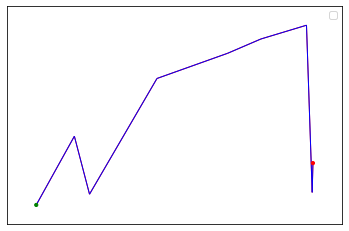

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


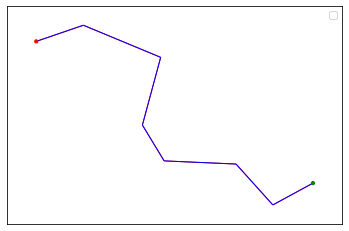

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


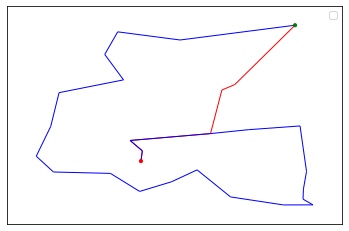

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


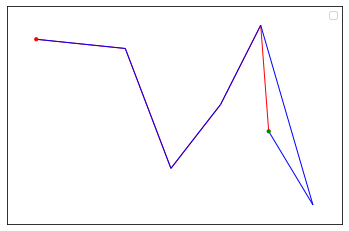

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


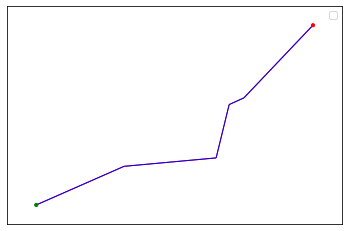

5 out of 5 can find path: 1.000000
3 out of 5 can find optimal path: 0.600000
3 out of 5 all paths can find optimal paths: 0.600000
5 pairs, μ=0.816667, σ=0.290593
5 pairs, μ=0.808284, σ=0.275283
Overall efficiency=  0.9058186600991741
Route1
Route2
Route3
Route4
Route5


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


380
/content/drive/MyDrive/project3/graph.png


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import anvil.media
import os

@anvil.server.callable
def show_graph():
  filename="/content/drive/MyDrive/project3/graph.png"
  
  G=generate_low_degree_g()
  while nx.is_connected(G) == False:
    G = generate_low_degree_g()
  pos = {}
  for t in G.nodes:
        pos[t] = (G.nodes[t]['x'], G.nodes[t]['y'])
  
  nx.draw(G, pos=pos, node_size=200, font_size=8, with_labels=True)
  
  print(filename)
  
  plt.savefig(filename)
  plt.clf()
  img=anvil.media.from_file(filename)
  os.remove(filename)
  
  return img


@anvil.server.callable
def calc_routes(src1,dest1,src2,dest2,src3,dest3,src4,dest4,src5,dest5):
  routes_list=[]
   
  features, labels, selected_pairs, pair_path_dict =\
          generate_stochastic_dataset_routes(G, src1,dest1,src2,dest2,src3,dest3,src4,dest4,src5,dest5)
      
  


  print_paths_statistics(G,\
                       num_to_test=5,\
                       pair_path_dict=pair_path_dict,
                       verbose=True)

  return routes_list

@anvil.server.callable
def show_route(name):
  filename=""
  print(name)
  if name =="Route1":
    filename="/content/drive/MyDrive/project3/route0.png"
  if name =="Route2":
    filename="/content/drive/MyDrive/project3/route1.png"
  if name =="Route3":
    filename="/content/drive/MyDrive/project3/route2.png"
  if name =="Route4":
    filename="/content/drive/MyDrive/project3/route3.png"
  if name =="Route5":
    filename="/content/drive/MyDrive/project3/route4.png"
  
  img=anvil.media.from_file(filename)
  return img
anvil.server.wait_forever()